In [1]:
import numpy as np 
from matplotlib import pyplot as plt 
import seaborn as sns 
from tqdm import tqdm 
from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestClassifier  , AdaBoostClassifier , GradientBoostingClassifier
from sklearn.metrics import precision_score , recall_score 
import xgboost as xgb 
import pandas as pd 
import sklearn.neighbors._base
from os import sys
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base
from missingpy import MissForest 
from sklearn.metrics import confusion_matrix , ConfusionMatrixDisplay
sns.set_style('whitegrid')
%load_ext autoreload
%autoreload 2
sns.set_style('whitegrid')
from IPython.display import display

In [2]:
def details(data_sent , comments = ''):
    if(comments):
        print(comments)
    sp = (data_sent.isna().sum().sum())/ data_sent.size
    print('________________________________________________')
    print('Sparsity in the data : {:.2f}'.format(sp))
    num_rows = data_sent.shape
    print('Data shape' , num_rows)
    #display(data_sent['class'].value_counts())
    print('Number of sources : ')
    cl = data_sent['class'].unique()
    for c in cl:
        num_src = len(data_sent[data_sent['class']==c]['src_id'].unique())
        num_obs = len(data_sent[data_sent['class']==c])
        print(c ,' \t ' , num_src , '\t' , num_obs)

In [3]:
from features import phot_flux , en_flux , hard, powlaw_fit , bb_fit , brems_fit , intra_obs_var , inter_ob_var , info_col , phot_flux_hilim , phot_flux_lolim , en_flux_hilim , en_flux_lolim

In [4]:
info_col_cl =  info_col+['class']

In [5]:
data_imp_v2 = pd.read_csv('imputed_data/old-data-all-at-once-imp.csv' , index_col='obs_id')

In [6]:
details(data_imp_v2)

________________________________________________
Sparsity in the data : 0.00
Data shape (1812, 58)
Number of sources : 
CV  	  60 	 994
PL  	  92 	 297
LX  	  58 	 521


In [7]:

df_comb = pd.DataFrame()
for s in data_imp_v2['src_id'].unique()[:]:
    temp = data_imp_v2[data_imp_v2['src_id']==s]
    temp_id =  temp[info_col_cl]
    temp_val = temp.drop(columns=info_col_cl)
    temp_mean = temp_val.mean().to_frame().T
    temp_id_top = temp_id.iloc[0:1].reset_index()
    temp_final = pd.concat([temp_id_top , temp_mean] , axis=1).set_index('obs_id')
    df_comb = df_comb.append(temp_final)
display(df_comb)


,src_id,num_obs,src_n,name,ra,dec,livetime,significance,likelihood,class,...,var_prob_b,photflux_aper_s,var_inter_index_h,var_inter_index_m,flux_aper_lolim_m,photflux_aper_lolim_m,flux_aper_s,photflux_aper_lolim_s,flux_aper_lolim_s,var_inter_index_s
obs_id,,,,,,,,,,,,,,,,,,,,,
CV_0_obs_0,CV_0,33,[HPH2013]_176__________,2CXO J004245.0+411520,10.68773,41.255820,4903.5,11.31,304.46460,CV,...,0.519053,6.171487,5.201515,5.256667,14.979031,6.309536,14.976276,6.707052,15.440544,4.211515
CV_1_obs_0,CV_1,104,[HPH2013]_142__________,2CXO J004242.9+411543,10.67917,41.261980,4035.0,77.08,27912.78000,CV,...,0.212598,4.820819,6.000000,5.000000,13.739299,5.048415,13.652316,5.010062,13.844925,5.000000
CV_2_obs_0,CV_2,102,[HPH2013]_169__________,2CXO J004244.3+411607,10.68489,41.268730,4035.0,83.08,37399.46000,CV,...,0.307392,4.854613,8.000000,8.000000,14.149360,5.523214,13.530381,5.077632,13.751917,8.000000
CV_3_obs_0,CV_3,102,XMMSL2_J004231.9+411621,2CXO J004231.1+411621,10.62976,41.272670,4913.0,174.76,172643.30000,CV,...,0.096272,4.195978,7.000000,5.000000,12.952036,4.309032,12.978640,4.264402,13.047099,4.000000
CV_4_obs_0,CV_4,97,[HPH2013]_205__________,2CXO J004248.7+411624,10.70297,41.273450,4881.4,33.19,3870.74300,CV,...,0.449750,5.484190,6.000000,6.000000,14.697235,6.026592,14.305337,6.029315,14.866403,6.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LMXB_86_obs_0,LMXB_86,1,SAX_J1810.8-2609_____,2CXO J181044.4-260901,272.68530,-26.150370,31871.5,9.29,512.97550,LX,...,0.084000,5.338755,5.010000,5.050000,14.444543,5.786217,14.189364,5.405497,14.260507,4.450000
LMXB_90_obs_0,LMXB_90,1,XTE_J2123-058________,2CXO J212314.5-054753,320.81060,-5.798128,17705.1,4.06,132.76700,LX,...,0.807000,5.737786,5.000000,5.100000,15.478078,6.884057,14.499626,5.889410,14.651500,4.460000
LMXB_91_obs_0,LMXB_91,1,XB_1732-304__________,2CXO J173547.0-302858,263.94590,-30.482820,18855.8,4.89,114.24570,LX,...,0.451000,6.466864,3.000000,5.000000,14.373147,5.747875,15.291664,7.068949,15.893809,3.000000


In [8]:
data_id = df_comb[info_col]
data_label = df_comb['class']
data_val = df_comb.drop(columns=['class']+info_col)
data_imp_norm = df_comb.copy()
for c in data_val.columns.to_list():
    data_imp_norm.loc[:,c] = (data_imp_norm.loc[:,c] - data_imp_norm.loc[:,c].mean()) / data_imp_norm.loc[:,c].std()
data_imp_norm

,src_id,num_obs,src_n,name,ra,dec,livetime,significance,likelihood,class,...,var_prob_b,photflux_aper_s,var_inter_index_h,var_inter_index_m,flux_aper_lolim_m,photflux_aper_lolim_m,flux_aper_s,photflux_aper_lolim_s,flux_aper_lolim_s,var_inter_index_s
obs_id,,,,,,,,,,,,,,,,,,,,,
CV_0_obs_0,CV_0,33,[HPH2013]_176__________,2CXO J004245.0+411520,10.68773,41.255820,4903.5,11.31,304.46460,CV,...,0.701065,0.730713,-0.320265,-0.153136,0.794837,0.727087,0.814387,1.057429,0.981106,-0.466188
CV_1_obs_0,CV_1,104,[HPH2013]_142__________,2CXO J004242.9+411543,10.67917,41.261980,4035.0,77.08,27912.78000,CV,...,-0.589881,-1.027547,0.162591,-0.311327,-0.988111,-1.081884,-0.937379,-0.928226,-0.846571,-0.013983
CV_2_obs_0,CV_2,102,[HPH2013]_169__________,2CXO J004244.3+411607,10.68489,41.268730,4035.0,83.08,37399.46000,CV,...,-0.190559,-0.983555,1.372020,1.537661,-0.398373,-0.400824,-1.098715,-0.849163,-0.953106,1.706550
CV_3_obs_0,CV_3,102,XMMSL2_J004231.9+411621,2CXO J004231.1+411621,10.62976,41.272670,4913.0,174.76,172643.30000,CV,...,-1.079908,-1.840947,0.767305,-0.311327,-2.120331,-2.142465,-1.828737,-1.800727,-1.760429,-0.587495
CV_4_obs_0,CV_4,97,[HPH2013]_205__________,2CXO J004248.7+411624,10.70297,41.273450,4881.4,33.19,3870.74300,CV,...,0.409124,-0.163991,0.162591,0.305002,0.389566,0.321228,-0.073350,0.264406,0.323465,0.559528
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LMXB_86_obs_0,LMXB_86,1,SAX_J1810.8-2609_____,2CXO J181044.4-260901,272.68530,-26.150370,31871.5,9.29,512.97550,LX,...,-1.131602,-0.353313,-0.436077,-0.280511,0.026151,-0.023570,-0.226797,-0.465527,-0.370550,-0.329415
LMXB_90_obs_0,LMXB_90,1,XTE_J2123-058________,2CXO J212314.5-054753,320.81060,-5.798128,17705.1,4.06,132.76700,LX,...,1.914046,0.166134,-0.442124,-0.249694,1.512552,1.551189,0.183719,0.100702,0.077308,-0.323679
LMXB_91_obs_0,LMXB_91,1,XB_1732-304__________,2CXO J173547.0-302858,263.94590,-30.482820,18855.8,4.89,114.24570,LX,...,0.414391,1.115226,-1.651553,-0.311327,-0.076529,-0.078567,1.231685,1.480886,1.500292,-1.161006


In [9]:
details(data_imp_norm)

________________________________________________
Sparsity in the data : 0.00
Data shape (210, 58)
Number of sources : 
CV  	  60 	 60
PL  	  92 	 92
LX  	  58 	 58


In [15]:
verbose = 0
val_acc = []
test_acc = []
for i in tqdm(range(32)):
    src_list = pd.DataFrame()
    class_to_select = ['CV' , 'LX' , 'PL']
    df = data_imp_norm.copy()
    i_val = df[info_col]
    y_val = df['class']
    x_val = df.drop(columns=['class']+info_col)

    clf = RandomForestClassifier(
        n_estimators = 200 , n_jobs=-1
    )
    #clf = AdaBoostClassifier(base_estimator=clf ,)
    #clf = xgb.XGBRFClassifier(n_componets=200)
    #clf = xgb.XGBClassifier()
    x_train , x_test , y_train , y_test = train_test_split(x_val , y_val , test_size=0.2 , stratify=y_val, random_state=42)
    #x_train , y_train = train_value , train_label
    clf.fit(x_train , y_train)
    v_sc = clf.score(x_test , y_test)
    test_sc = clf.score(x_train, y_train)
    val_acc.append(v_sc)
    test_acc.append(test_sc)
    #if(verbose):
    print(test_sc , v_sc)

  3%|▎         | 1/32 [00:00<00:22,  1.36it/s]

0.9642857142857143 0.6428571428571429


  6%|▋         | 2/32 [00:01<00:24,  1.24it/s]

0.9642857142857143 0.6666666666666666


  9%|▉         | 3/32 [00:02<00:27,  1.07it/s]

0.9642857142857143 0.6666666666666666


 12%|█▎        | 4/32 [00:03<00:26,  1.06it/s]

0.9642857142857143 0.6666666666666666


 16%|█▌        | 5/32 [00:04<00:24,  1.09it/s]

0.9642857142857143 0.6428571428571429


 19%|█▉        | 6/32 [00:05<00:22,  1.17it/s]

0.9642857142857143 0.6666666666666666


 22%|██▏       | 7/32 [00:05<00:20,  1.21it/s]

0.9642857142857143 0.6666666666666666


 25%|██▌       | 8/32 [00:06<00:19,  1.25it/s]

0.9642857142857143 0.6666666666666666


 28%|██▊       | 9/32 [00:07<00:20,  1.13it/s]

0.9642857142857143 0.6666666666666666


 31%|███▏      | 10/32 [00:08<00:19,  1.13it/s]

0.9642857142857143 0.6904761904761905


 34%|███▍      | 11/32 [00:09<00:18,  1.14it/s]

0.9642857142857143 0.6428571428571429


 38%|███▊      | 12/32 [00:10<00:18,  1.11it/s]

0.9642857142857143 0.6904761904761905


 41%|████      | 13/32 [00:11<00:17,  1.08it/s]

0.9642857142857143 0.6666666666666666


 44%|████▍     | 14/32 [00:12<00:15,  1.15it/s]

0.9642857142857143 0.6428571428571429


 47%|████▋     | 15/32 [00:13<00:14,  1.15it/s]

0.9642857142857143 0.6904761904761905


 50%|█████     | 16/32 [00:13<00:13,  1.20it/s]

0.9642857142857143 0.6428571428571429


 53%|█████▎    | 17/32 [00:14<00:13,  1.15it/s]

0.9642857142857143 0.6428571428571429


 56%|█████▋    | 18/32 [00:15<00:11,  1.20it/s]

0.9642857142857143 0.6428571428571429


 59%|█████▉    | 19/32 [00:16<00:10,  1.24it/s]

0.9642857142857143 0.6666666666666666


 62%|██████▎   | 20/32 [00:17<00:09,  1.26it/s]

0.9642857142857143 0.6666666666666666


 66%|██████▌   | 21/32 [00:17<00:08,  1.28it/s]

0.9642857142857143 0.6666666666666666


 69%|██████▉   | 22/32 [00:18<00:07,  1.30it/s]

0.9642857142857143 0.6904761904761905


 72%|███████▏  | 23/32 [00:19<00:07,  1.25it/s]

0.9642857142857143 0.6666666666666666


 75%|███████▌  | 24/32 [00:20<00:06,  1.18it/s]

0.9642857142857143 0.6904761904761905


 78%|███████▊  | 25/32 [00:21<00:05,  1.22it/s]

0.9642857142857143 0.6904761904761905


 81%|████████▏ | 26/32 [00:22<00:05,  1.11it/s]

0.9642857142857143 0.6904761904761905


 84%|████████▍ | 27/32 [00:23<00:04,  1.09it/s]

0.9642857142857143 0.6904761904761905


 88%|████████▊ | 28/32 [00:24<00:03,  1.11it/s]

0.9642857142857143 0.6666666666666666


 91%|█████████ | 29/32 [00:24<00:02,  1.17it/s]

0.9642857142857143 0.6904761904761905


 94%|█████████▍| 30/32 [00:25<00:01,  1.12it/s]

0.9642857142857143 0.6666666666666666


 97%|█████████▋| 31/32 [00:26<00:00,  1.10it/s]

0.9642857142857143 0.6904761904761905


100%|██████████| 32/32 [00:27<00:00,  1.17it/s]

0.9642857142857143 0.6904761904761905


In [16]:
score = pd.DataFrame({
    "Test Score" : test_acc, 
    "Validation Score" : val_acc
})*100
score.describe().loc[['mean' , 'std' , 'min', 'max' ]]

,Test Score,Validation Score
mean,96.428571,66.964286
std,0.000000,1.788912
min,96.428571,64.285714
max,96.428571,69.047619


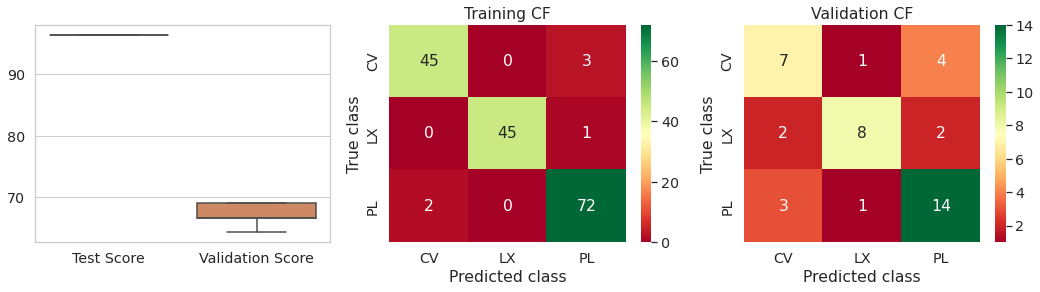

In [17]:
sns.set(font_scale=1.3)
sns.set_style('whitegrid')
fig , ax = plt.subplots(nrows=1 , ncols=3 , figsize = (18 , 4))
sns.boxplot(data = score , ax = ax[0])
cf = confusion_matrix(y_train , clf.predict(x_train) ,)
sns.heatmap(cf , annot=True ,fmt = '.0f' , ax = ax[1] , xticklabels =class_to_select , yticklabels = class_to_select  , cmap='RdYlGn' ,)
cf = confusion_matrix(y_test , clf.predict(x_test) ,)
sns.heatmap(cf , annot=True ,fmt = '.0f' , ax = ax[2] , xticklabels=class_to_select, yticklabels = class_to_select , cmap='RdYlGn')
ax[1].set_title('Training CF')
ax[2].set_title('Validation CF')
for a in ax[1:]:
    a.set_xlabel('Predicted class')
    a.set_ylabel('True class')

plt.show()
#score